In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot
import os 
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from data_helper import (MyDataset, denormal, toRGB)
from FCN import FCN

In [2]:
batch_size, n_class, h, w = 10, 2, 224, 320
image_shape = (h, w, 3)
# please download dataset and training the model first
home = os.path.expanduser('~')
data_dir = os.path.join(home, 'workspace', 'deeplearning', 'dataset', 'kitti', 'data_road')
saved_model_dir = os.path.join(home, 'workspace', 'deeplearning', 'FCN', 'saved', 'FCNs_new.pth')

myTrainDataset = MyDataset(data_dir, image_shape=image_shape, isTrain=True, n_class=n_class)
myDataLoader = DataLoader(myTrainDataset, batch_size=batch_size, shuffle=True)

myTestDataset = MyDataset(data_dir, image_shape=image_shape, isTrain=False, n_class=n_class)
myTestDataLoader = DataLoader(myTestDataset, batch_size=batch_size, shuffle=True)

In [3]:
_train_batch = next(iter(myDataLoader))
_train_X, _train_Y = Variable(_train_batch['X']), Variable(_train_batch['Y'])

_test_batch = next(iter(myTestDataLoader))
_test_X = Variable(_test_batch['X'])

In [4]:
model = FCN(n_class=n_class)
own_state_dict = torch.load(saved_model_dir)
model.load_state_dict(own_state_dict)

In [5]:
lr = 1e-4
momentum = 0
w_decay = 1e-5
step_size = 50
gamma = 0.5

loss = nn.BCEWithLogitsLoss()
optimizer = optim.RMSprop(model.parameters(), lr=lr, momentum=momentum, weight_decay=w_decay)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)  # decay LR by a factor of 0.5 every 30 epochs

In [6]:
epochs = 1 #10
steps = 1 #30

for ep in range(epochs):
    scheduler.step()
    for i in range(steps):
        batch = next(iter(myDataLoader))
        inputs, targets = Variable(batch['X']), Variable(batch['Y'], requires_grad=False)
        optimizer.zero_grad()
        predict = model(inputs)
        loss_result = loss(predict, targets)
        loss_result.backward()
        print("ep: {}, times: {}/{}, loss: {}".format(ep+1, i+1, steps, loss_result.item()))
        optimizer.step()
    print("finish: {}/{}".format(ep+1, epochs))
    print("=========="*10)

ep: 1, times: 1/1, loss: 0.4003514349460602
finish: 1/1


In [7]:
outputs = model(_test_X)
outputs = outputs.data.cpu().numpy()

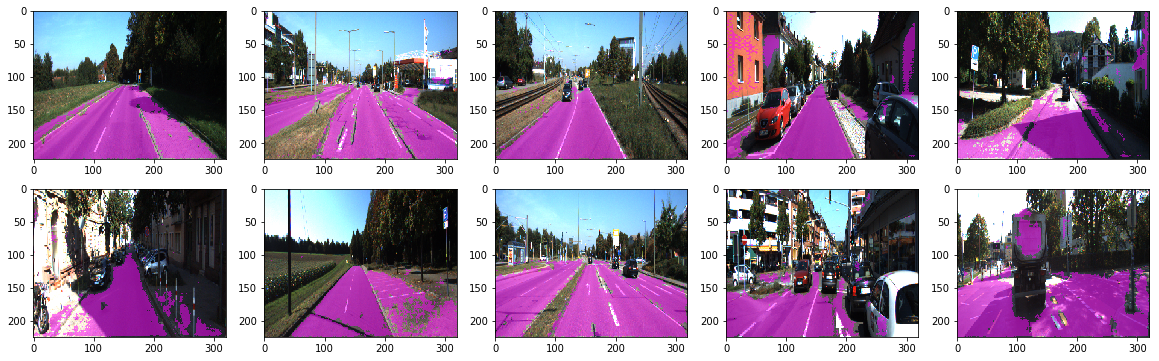

In [31]:
threshold = 0.7 # gap of probability
_cls_id = 1 # road

fig, ax = pyplot.subplots(2, 5, figsize=(20, 6))
dinputs = denormal(_test_X)
dinputs = toRGB(dinputs, dtype=np.uint8)
for i in range(10):
    N, H, W = outputs[i].shape
    # raw
    street_im = Image.fromarray(dinputs[i])
    # semantic road
    im_softmax = outputs[i].transpose(1, 2, 0)[:, :, _cls_id]
    segmentation = (im_softmax > threshold).reshape(H, W, 1)
    # mask
    mask = np.dot(segmentation, np.array([[255, 0, 255, 127]]))
    mask = np.round(mask).astype(np.uint8)
    mask = Image.fromarray(mask, mode="RGBA")
    # paste
    street_im.paste(mask, box=None, mask=mask)
    ax[i//5][i%5].imshow(street_im, aspect='auto')
pyplot.show()

In [32]:
# torch.save(model.state_dict(), os.path.join('saved', '_FCNs.pth'))